In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
train_data = datasets.CIFAR10(
    root = "data",
    train = True,
    download = True,
    transform = ToTensor()
)
test_data = datasets.CIFAR10(
    root = "data",
    train = False,
    download = True,
    transform = ToTensor()
)

100%|██████████| 170498071/170498071 [00:08<00:00, 20827212.17it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [4]:
batch_size = 64

train_dataloader = DataLoader(train_data, batch_size = batch_size, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = batch_size, shuffle = False)

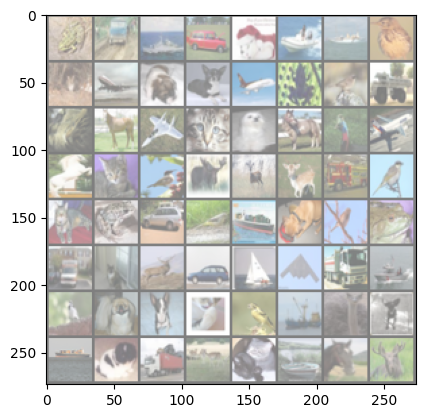

Frog  Truck Ship  Car   Cat   Ship  Ship  Bird  Cat   plane Dog   Dog   plane Frog  Bird  Truck Cat   Horse plane Cat   Dog   Horse Bird  plane Horse Cat   Bird  Deer  Deer  Deer  Truck Bird  Cat   Frog  Car   Bird  Ship  Dog   Bird  Frog  Truck Cat   Deer  Car   Ship  plane Truck Ship  Bird  Dog   Dog   Cat   Bird  Ship  Bird  Dog   Ship  Dog   Truck Deer  Cat   Ship  Horse Deer 


In [5]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

classes = ("plane", "Car", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck")

def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
images, labels = next(iter(train_dataloader))

imshow(make_grid(images))

print(" ".join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [6]:
import torch.nn.functional as F

class CIFARnet(nn.Module):
    def __init__(self):
        super(CIFARnet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = CIFARnet().to(device)
net

CIFARnet(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)

In [8]:
num_epoch = 20

net.train()
train_loss = []
for epoch in range(num_epoch):
    
    running_loss = 0.0
    for i, (inputs, lables) in enumerate(train_dataloader, 0):
        inputs, lables = inputs.to(device), lables.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    train_loss.append(running_loss/2000)
print('Finished Training')

Finished Training


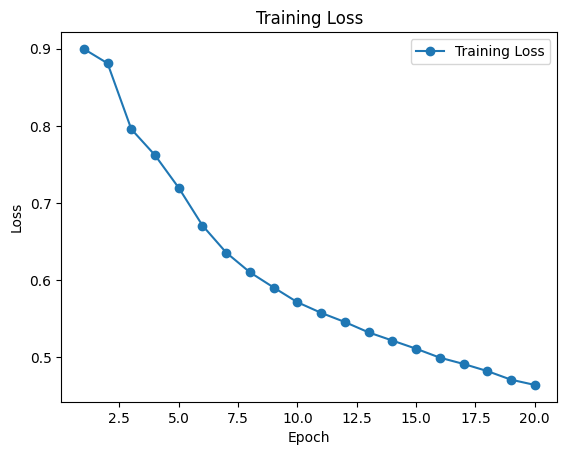

In [9]:
import matplotlib.pyplot as plt

epochs =  np.arange(1, len(train_loss) + 1)
# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Display the plot
plt.show()

In [10]:
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move both images and labels to the same device
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 56 %


In [11]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
    
        outputs = net(images)
        
        _,predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 64.2 %
Accuracy for class: Car   is 61.0 %
Accuracy for class: Bird  is 39.8 %
Accuracy for class: Cat   is 42.7 %
Accuracy for class: Deer  is 37.7 %
Accuracy for class: Dog   is 49.5 %
Accuracy for class: Frog  is 65.9 %
Accuracy for class: Horse is 65.5 %
Accuracy for class: Ship  is 73.1 %
Accuracy for class: Truck is 66.3 %


# Applying Batch Normalization

In [24]:
import torch.nn as nn

class BatchCIFARnet(nn.Module):
    def __init__(self):
        super(BatchCIFARnet, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, 5, padding=2),  # Padding should be specified as an integer
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(32)  # Batch normalization after the first convolution
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, 5, padding=2),  # Padding should be specified as an integer
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.BatchNorm2d(64)  # Batch normalization after the second convolution
        )
        
        self.fc1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4096, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),  # Batch normalization after the first fully connected layer
            nn.Dropout(0.5),
            nn.Linear(1024, 10)
        )

    def forward(self, x):
        x = x.float()
        x = self.conv1(x)
        x = self.conv2(x)
        return self.fc1(x)
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = BatchCIFARnet().to(device)
net

BatchCIFARnet(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=4096, out_features=1024, bias=True)
    (2): ReLU()
    (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=1024, out_features=10, bias=True)
  )
)

In [25]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr = 1e-4)

In [26]:
num_epoch = 20

net.train()
train_loss = []
for epoch in range(num_epoch):
    
    running_loss = 0.0
    for i, (inputs, lables) in enumerate(train_dataloader, 0):
        inputs, lables = inputs.to(device), lables.to(device)
        
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, lables)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0
    train_loss.append(running_loss/2000)
print('Finished Training')

Finished Training


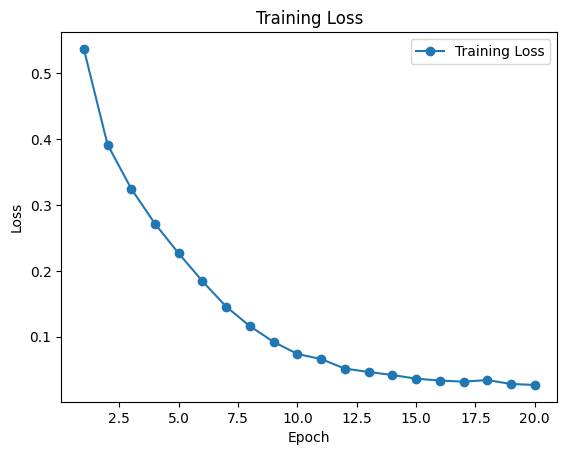

In [27]:
import matplotlib.pyplot as plt

epochs =  np.arange(1, len(train_loss) + 1)
# Plot training loss
plt.plot(epochs, train_loss, label='Training Loss', marker='o')

# Add labels and a legend
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

# Display the plot
plt.show()

In [28]:
correct = 0
total = 0

net.eval()
with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)  # Move both images and labels to the same device
        
        outputs = net(images)
        
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 71 %


In [29]:
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
    
        outputs = net(images)
        
        _,predictions = torch.max(outputs, 1)
        
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
            
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: plane is 73.9 %
Accuracy for class: Car   is 80.1 %
Accuracy for class: Bird  is 62.0 %
Accuracy for class: Cat   is 50.5 %
Accuracy for class: Deer  is 71.1 %
Accuracy for class: Dog   is 59.5 %
Accuracy for class: Frog  is 82.3 %
Accuracy for class: Horse is 76.9 %
Accuracy for class: Ship  is 81.1 %
Accuracy for class: Truck is 82.5 %
